# Heston 

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
from heston_model import *
import scipy.stats as stats
from numpy.random import default_rng, SeedSequence
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt


# test semi-closed form solution

In [53]:
def d_plus(s,k,v):
    return np.log(s/k)/np.sqrt(v) + np.sqrt(v)/2

def d_minus(s,k,v):
    return np.log(s/k)/np.sqrt(v) - np.sqrt(v)/2
def Call(K,r = 0.05,q = 0, sigma = 0.3,S_0 = 100, T = 1.5):
    K_dc = K*np.exp(-r*T)
    S_f = S_0*np.exp(-q*T)
    return S_f*stats.norm.cdf(d_plus(S_f,K_dc,sigma**2*T))-K_dc*stats.norm.cdf(d_minus(S_f,K_dc,sigma**2*T))

In [54]:
params = {
    'T': 5.,
    'r': 0.05,
    'theta': 0.1,
    'k': 1,
    'sigma': 0.00001,
    'rho': 0,
    's0' : 1.0,
    'v0': 0.1
}

In [55]:
params_test = {
    'T': 5,
    'r': 0.05,
    'sigma': np.sqrt(0.1),
    'S_0': 1.,
    'K': 1
}

In [57]:
model = Heston(**params)
assert np.isclose(Call(**params_test),model.call(1) )

# test schema 

In [58]:
sq = SeedSequence()
rng = default_rng(sq)

In [79]:
params = {
    'T': 5.,
    'r': 0.05,
    'theta': 0.1,
    'k': 1.1,
    'sigma': 0.4,
    'rho': -0.6,
    's0' : 1.0,
    'v0': 0.1
}

In [80]:
def monte_carlo(sample, name='', proba=0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    quantile = sps.norm.ppf(1 - (1-proba)/2)
    ci_size = quantile * np.sqrt(var / sample.size)    
    result = pd.DataFrame(
        [mean, var, mean - ci_size, mean + ci_size], 
        index=("Mean","Var","Lower bound", "Upper bound"), 
        columns=[name])
    return result

In [88]:
def compute_call_heston(heston, scheme, steps, K, M = 10000):
    result = None
    sdict = { "Diop": heston.paths_euler_diop , "D-D": heston.paths_euler_dd}

    for N in steps:
        dW1 = np.sqrt(heston.T / N) * rng.standard_normal((N, M))
        dW2 = np.sqrt(heston.T / N) * rng.standard_normal((N, M))
        paths, vol = sdict[scheme](dW1,dW2)
        payoffs = np.exp(-heston.r * heston.T)* np.maximum(paths[N] - K, 0)
        result = pd.concat([result, monte_carlo(payoffs, f'{scheme}, N = {N}')], axis = 1)
    return result

In [104]:
heston = Heston(**params)
K = 0.5
M = int(1e6)
exact_price = heston.call(K)

In [103]:
exact_price

0.6345625199951872

In [111]:
steps = 2**np.arange(1,8)
res_Diop = compute_call_heston(heston, "Diop", steps, K = 0.5, M=M)

In [108]:
res_Diop

,"Diop, N = 2","Diop, N = 4","Diop, N = 8","Diop, N = 16","Diop, N = 32","Diop, N = 64","Diop, N = 128"
Mean,0.659439,0.659232,0.645082,0.639479,0.635836,0.635429,0.635841
Var,0.426880,0.560525,0.501241,0.460842,0.438127,0.429498,0.423983
Lower bound,0.658158,0.657765,0.643695,0.638148,0.634539,0.634145,0.634565
Upper bound,0.660719,0.660699,0.646470,0.640809,0.637134,0.636714,0.637117


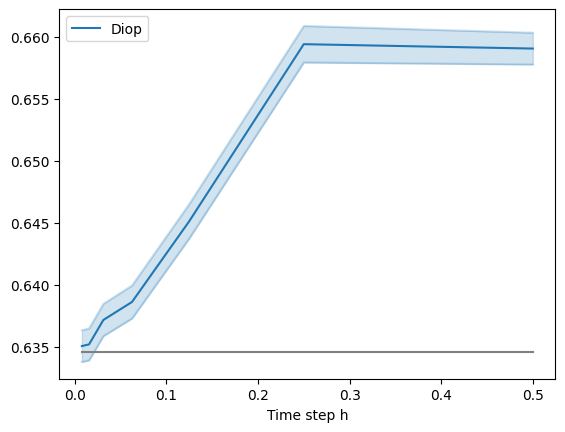

In [113]:
fig = plt.figure()
ress = [res_Diop.values]
names = ['Diop']
colors = ['C0', 'C1']
for res, name, color in zip(ress, names, colors):
    m, up, down = [res[0], res[2], res[3]]
    plt.plot(1/steps, m, color=color, label=name)
    plt.plot(1/steps, up, color=color, alpha=0.2)
    plt.plot(1/steps, down, color=color, alpha=0.2)
    plt.fill_between(1/steps, up, down, color=color, alpha=0.2)
    plt.plot(1/steps, exact_price*np.ones(len(steps)), color='grey')
plt.xlabel('Time step h')
plt.legend()
plt.show()